In [ ]:
!pip install scikit-uplift catboost==0.22 -U

     |████████████████████████████████| 64.4MB 53kB/s 


In [ ]:
import pandas as pd
df = pd.read_excel('/content/uplift_data.xlsx')#, index_col='account_rk')
df = df.sample(frac=1)

In [ ]:
df.columns

Index(['account_rk', 'statement_dt', 'curr_due_dt', 'miss_due_cnt', 'dt',
       'bot_fio', 'bot_mp', 'p_def', 'w', 'y', 'due_by_limit_100',
       'balance_by_limit', 'due_by_balance', 'max_missed_due_cnt',
       'statement_num', 'onse_was_tunnel_flg', 'pd_base_calibrated', 'age',
       'gender_cd', 'education_level_cd', 'marital_status_cd', 'children_cnt',
       'monthly_income_amt', 'due_by_income', 'time_zone_cd',
       'job_position_cd'],
      dtype='object')

In [ ]:
df_ = df.copy()
df_ = df_.drop(['statement_dt','curr_due_dt', 'miss_due_cnt', 'dt'], axis=1)
df_['new_rk'] = df_['account_rk'].astype(str) + df_['statement_num'].astype(str) + df_['statement_num'].astype(str)
df_ = df_.drop_duplicates(subset=['new_rk'])
df_ = df_.drop(['account_rk'], axis=1)
df_ = df_.set_index('new_rk')
len(df_[df_['balance_by_limit'].isnull()])
#len(df_[df_.duplicated(keep=False, subset=['new_rk'])].sort_values(by=['new_rk']))

1617

In [ ]:
df_clients = df_.drop(['w','y'], axis=1)
df_clients

,bot_fio,bot_mp,p_def,due_by_limit_100,balance_by_limit,due_by_balance,max_missed_due_cnt,statement_num,onse_was_tunnel_flg,pd_base_calibrated,age,gender_cd,education_level_cd,marital_status_cd,children_cnt,monthly_income_amt,due_by_income,time_zone_cd,job_position_cd
new_rk,,,,,,,,,,,,,,,,,,,
491108021919,1,1,0.041201,0.053846,0.930147,0.057890,0,19,N,0.014,43.0,F,GRD,MAR,0,15000.0,0.186667,3,BIS
404636562828,1,0,0.064801,0.035000,0.967519,0.036175,0,28,N,0.064,39.0,F,SCH,DIV,2,50000.0,0.028000,3,SPC
659245251111,1,1,0.601470,0.120000,0.996714,0.120396,1,11,N,0.209,31.0,F,SCH,MAR,0,NaN,NaN,3,SPC
567707361818,0,0,0.799017,0.120000,1.994808,0.060156,2,18,N,0.252,25.0,F,GRD,UNM,0,85000.0,0.197647,3,SPC
307377149149,0,0,0.142465,0.063333,1.050280,0.060301,1,149,N,0.039,68.0,F,GRD,MAR,2,NaN,NaN,3,PNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376917993333,1,1,0.580007,0.120000,0.987668,0.121498,1,33,N,0.147,27.0,F,SCH,DIV,0,20000.0,0.030000,5,none
542616241616,0,1,0.053225,0.075000,1.230845,0.060934,0,16,N,0.074,48.0,M,GRD,MAR,0,50000.0,0.048000,3,BIS
8283058466,0,1,0.028680,0.005455,0.064257,0.084887,0,6,N,0.016,63.0,F,UGR,MAR,0,24000.0,0.025000,3,PNA


In [ ]:
df_train = df_[0:int(len(df_) / 2)][['w','y']]
df_train

,w,y
new_rk,,
491108021919,0,1
404636562828,0,1
659245251111,0,1
567707361818,0,1
307377149149,0,1
...,...,...
9985475222,1,1
425698202626,1,1
8302658255,1,1


In [ ]:
df_test = pd.DataFrame(index=df_[int(len(df_) / 2):].index)
df_test

""
new_rk
468995432525
426067482828
8740400344
318886494141
632155721515
...
376917993333
542616241616
8283058466


In [ ]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)


X_train = df_clients.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'y']
treat_train = df_train.loc[indices_learn, 'w']

X_val = df_clients.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'y']
treat_val =  df_train.loc[indices_valid, 'w']

X_train_full = df_clients.loc[indices_train, :]
y_train_full = df_train.loc[:, 'y']
treat_train_full = df_train.loc[:, 'w']

X_test = df_clients.loc[indices_test, :]

cat_features = ['bot_mp','bot_fio','onse_was_tunnel_flg','gender_cd','education_level_cd','marital_status_cd','time_zone_cd','job_position_cd']

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [ ]:
len(df_clients), len(df_train), len(df_train)

(425788, 212894, 212894)

In [ ]:
len(X_train), len(y_train), len(treat_train)

(149025, 149025, 149025)

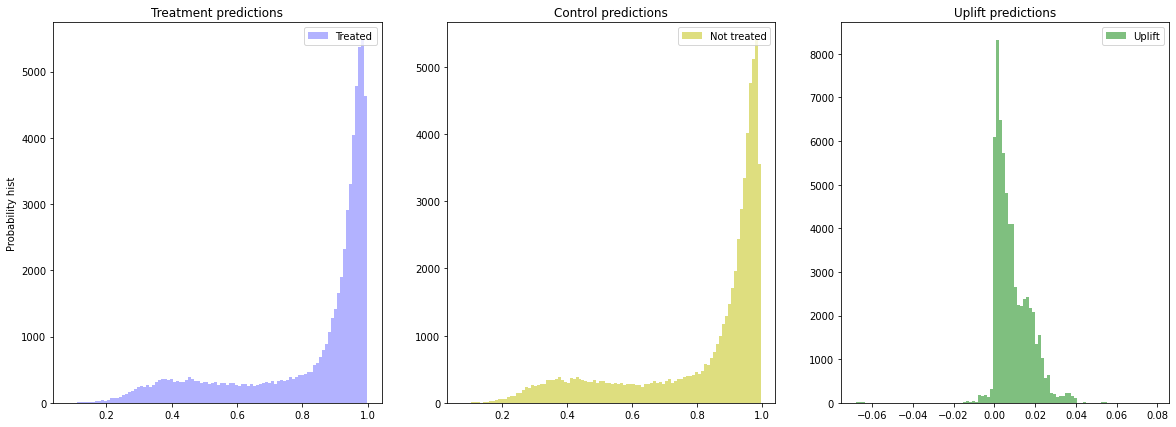

In [ ]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# Получим условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

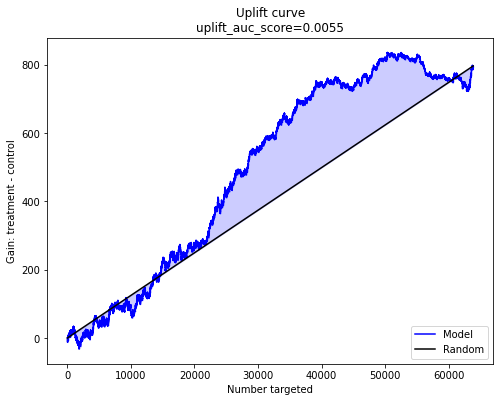

In [ ]:
from sklift.viz import plot_uplift_curve

# with ideal Qini curve (red line)
# perfect=True
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=False);

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


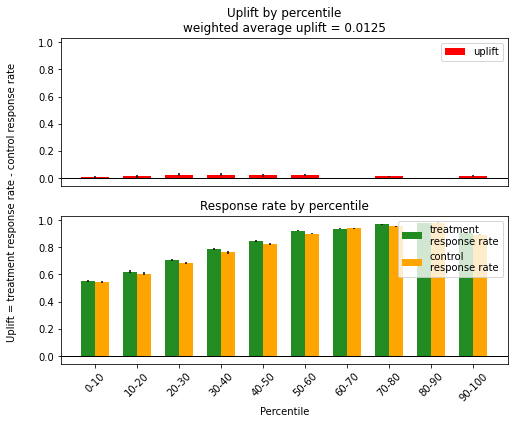

In [ ]:
from sklift.viz import plot_uplift_by_percentile


plot_uplift_by_percentile(y_val, uplift_sm, treat_val, 
                          strategy='overall', kind='bar');

In [ ]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,p_def,30.244245
1,pd_base_calibrated,26.365727
2,max_missed_due_cnt,16.579737
3,balance_by_limit,9.199185
4,statement_num,4.362261
5,due_by_balance,3.162484
6,due_by_limit_100,2.828143
7,education_level_cd,1.974760
8,age,1.086647
9,onse_was_tunnel_flg,0.841990


In [ ]:

from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


In [ ]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi

,feature_name,feature_score
0,bot_mp,36.626071
1,p_def,26.800308
2,bot_fio,23.028128
3,pd_base_calibrated,6.576560
4,balance_by_limit,1.564973
5,due_by_balance,1.109593
6,max_missed_due_cnt,1.079200
7,due_by_limit_100,0.761465
8,statement_num,0.709522
9,monthly_income_amt,0.386132


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


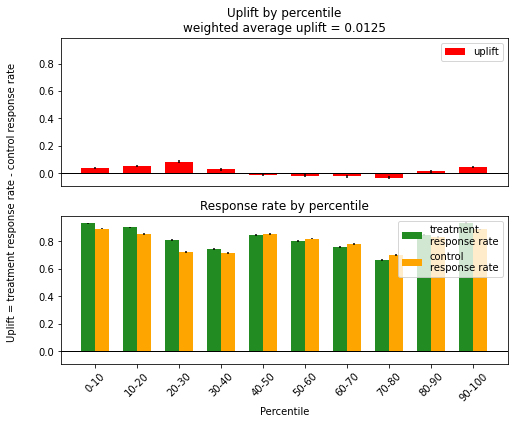

In [ ]:
from sklift.viz import plot_uplift_by_percentile


plot_uplift_by_percentile(y_val, uplift_ct, treat_val, 
                          strategy='overall', kind='bar');

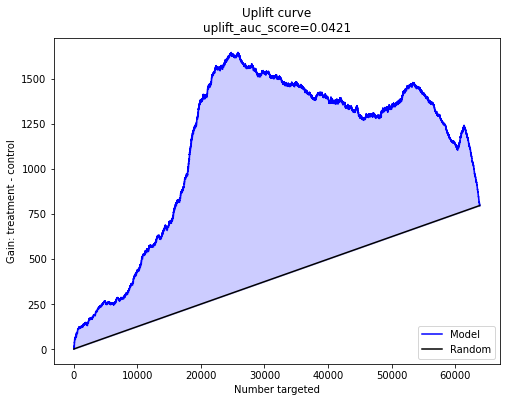

In [ ]:
from sklift.viz import plot_uplift_curve

# with ideal curve
# perfect=True
plot_uplift_curve(y_val, uplift_ct, treat_val, perfect=False);

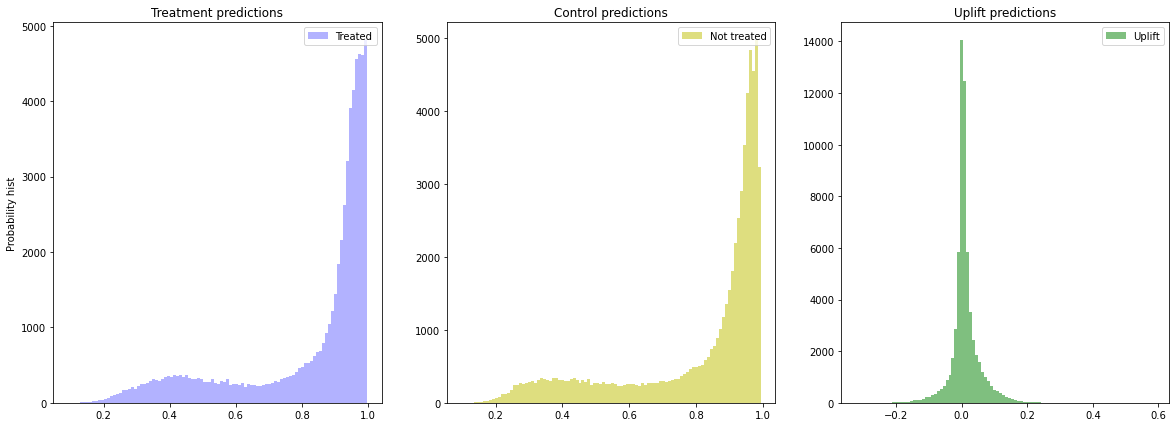

In [ ]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

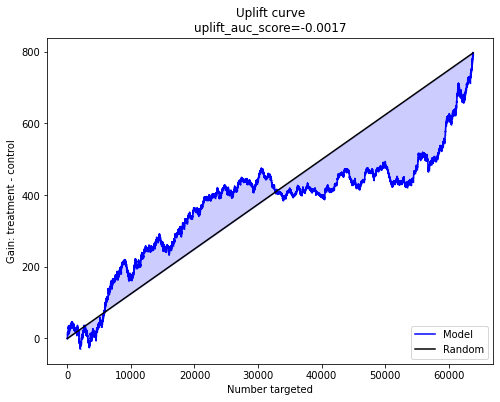

In [ ]:
from sklift.viz import plot_qini_curve

# with ideal Qini curve (red line)
# perfect=True
plot_uplift_curve(y_val, uplift_tm, treat_val, perfect=False);

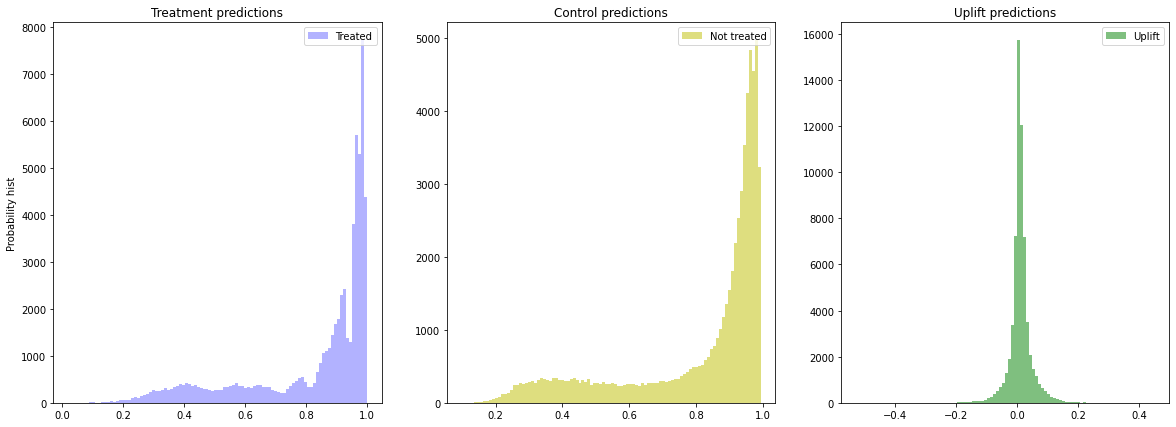

In [ ]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

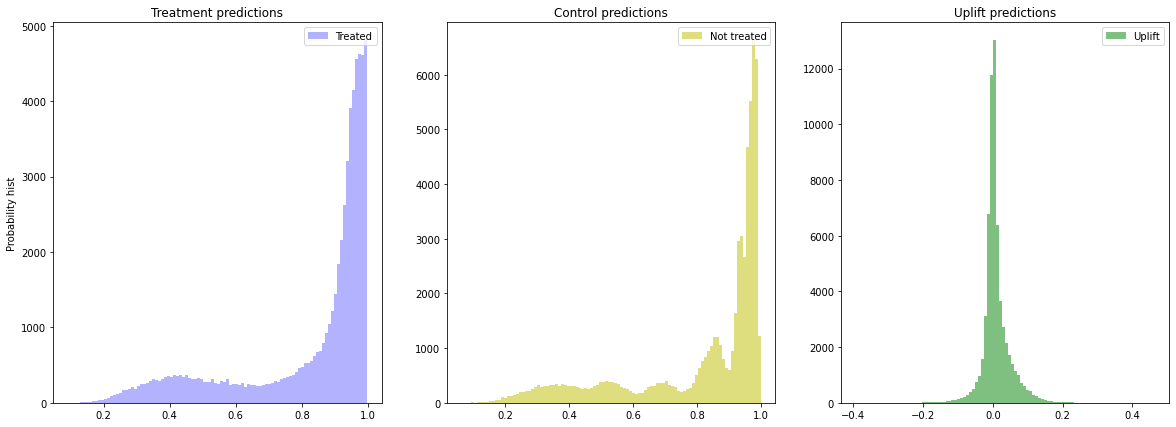

In [ ]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_trmnt = tm_trmnt.predict(X_val)

tm_trmnt_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_trmnt, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

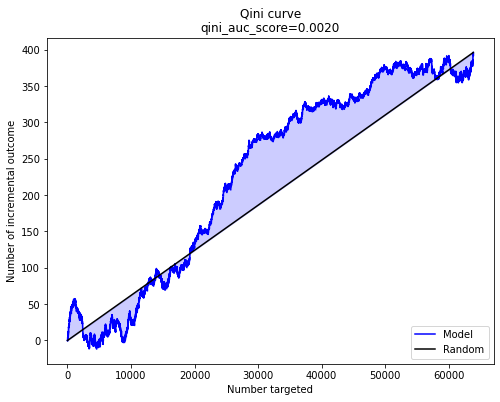

In [ ]:
from sklift.viz import plot_qini_curve

# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_val, uplift_tm_trmnt, treat_val, perfect=False);

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
1,ClassTransformation,0.118679
2,TwoModels,0.017293
4,TwoModels_ddr_treatment,0.017164
0,SoloModel,0.012415
3,TwoModels_ddr_control,0.009058


In [ ]:
ct_full = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct_full = ct_full.fit(
    X_train_full, 
    y_train_full, 
    treat_train_full, 
    estimator_fit_params={'cat_features': cat_features}
)

X_test.loc[:, 'uplift'] = ct_full.predict(X_test.values)

sub = X_test[['uplift']].to_csv('sub1.csv')

!head -n 5 sub1.csv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


new_rk,uplift
468995432525,0.03583871465503452
426067482828,0.2945961742977936
8740400344,0.011395629016284214
318886494141,0.2791257313548199


In [ ]:
ct_full_fi = pd.DataFrame({
    'feature_name': ct_full.estimator.feature_names_,
    'feature_score': ct_full.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_full_fi

,feature_name,feature_score
0,bot_mp,37.214402
1,p_def,24.967659
2,bot_fio,23.073151
3,pd_base_calibrated,7.317015
4,balance_by_limit,1.527758
5,age,0.947044
6,monthly_income_amt,0.845812
7,due_by_balance,0.792347
8,education_level_cd,0.628711
9,statement_num,0.528520
